In [1]:
import os
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

es_host = os.getenv("ELASTICSEARCH_HOST")
es_username = os.getenv("ELASTICSEARCH_USERNAME")
es_password = os.getenv("ELASTICSEARCH_PASSWORD")
es_ca_certs = os.getenv("ELASTICSEARCH_SSL_CERTIFICATEAUTHORITIES")


# Getting the todays and yesterdays date to understand the timeframe for visuals
current_date = datetime.now()
before_date = current_date - timedelta(days=1)
today = current_date.strftime("%Y-%m-%d")
yesterday = before_date.strftime("%Y-%m-%d")

print('Todays date is: ',today)
print('Yesterdays date is: ',yesterday)


#Testing Connection on ElasticSearch Engine
es = Elasticsearch(
    es_host,
    basic_auth=(es_username, es_password),
    ca_certs=es_ca_certs,
    verify_certs=True
)
print(es.info())

Todays date is:  2024-05-09
Yesterdays date is:  2024-05-08
{'name': 'es01', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'IF9xPO2HTfiDRVNCX23WQQ', 'version': {'number': '8.13.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '617f7b76c4ebcb5a7f1e70d409a99c437c896aea', 'build_date': '2024-04-29T22:05:16.051731935Z', 'build_snapshot': False, 'lucene_version': '9.10.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [2]:
# Function for extracting the latest 10.000 log entries to port 9200 (10.000 is the max limit)
def fetch_latest_logs(index='web-logs', size=10000):
    response = es.search(
        index=index,
        body={
            "size": size,  
            "query": {"match_all": {}},
            "sort": [{"timestamp": {"order": "desc"}}]
        }
    )
    
    logs = [hit['_source'] for hit in response['hits']['hits']]
    return logs

# Convert logs to a DataFrame for better visualization
logs_df = pd.DataFrame(fetch_latest_logs())

# Display the logs DataFrame
logs_df

,timestamp,ip,method,endpoint,response_code,response_time
0,2024-05-10T00:29:23,140.22.133.128,GET,list/category,201,403
1,2024-05-10T00:29:23,24.246.99.182,POST,blog,200,268
2,2024-05-10T00:29:23,110.242.163.132,GET,app,201,657
3,2024-05-10T00:29:23,77.212.183.151,POST,category,200,544
4,2024-05-10T00:29:23,1.116.145.134,GET,posts/categories/search,404,651
...,...,...,...,...,...,...
9995,2024-05-09T16:16:45,166.24.93.9,POST,category/explore/blog,200,688
9996,2024-05-09T16:16:44,162.120.231.52,GET,app/app,200,973
9997,2024-05-09T16:16:37,223.15.43.59,POST,posts,500,320
9998,2024-05-09T16:16:34,79.165.251.139,GET,categories/blog,201,243


## TRAFFIC PATTERN ANALYSIS

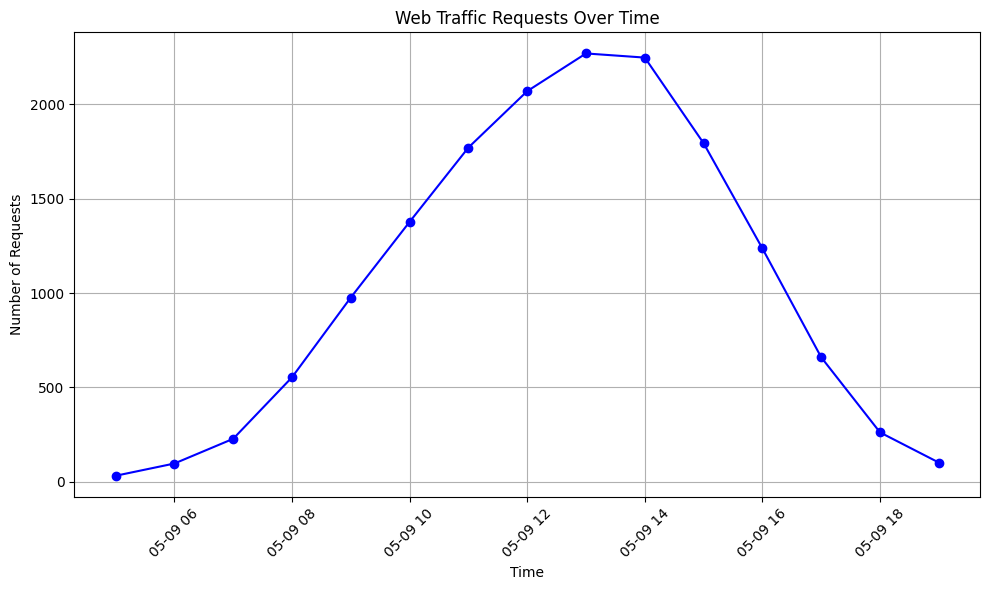

In [3]:
# Function to querry hourly log counts over a day period
def fetch_traffic_data(index, start_date, end_date):
    query = {
        "size": 0,
        "query": {
            "range": {
                "timestamp": {
                    "gte": start_date,
                    "lte": end_date,
                    "format": "yyyy-MM-dd"
                }
            }
        },
        "aggs": {
            "requests_over_time": {
                "date_histogram": {
                    "field": "timestamp",
                    "calendar_interval": "1h"
                }
            }
        }
    }
    result = es.search(index=index, body=query)
    buckets = result['aggregations']['requests_over_time']['buckets']
    return pd.DataFrame([(datetime.fromtimestamp(bkt['key']/1000), bkt['doc_count']) for bkt in buckets],
                        columns=['timestamp', 'count'])

# Plotting the daily traffic logs
df_traffic = fetch_traffic_data("web-logs",yesterday, today)

plt.figure(figsize=(10, 6))
plt.plot(df_traffic['timestamp'], df_traffic['count'], marker='o', linestyle='-', color='b')
plt.title('Web Traffic Requests Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout() 


## DAILY RESPONSE CODE AND METHOD DISTRIBUTIONS

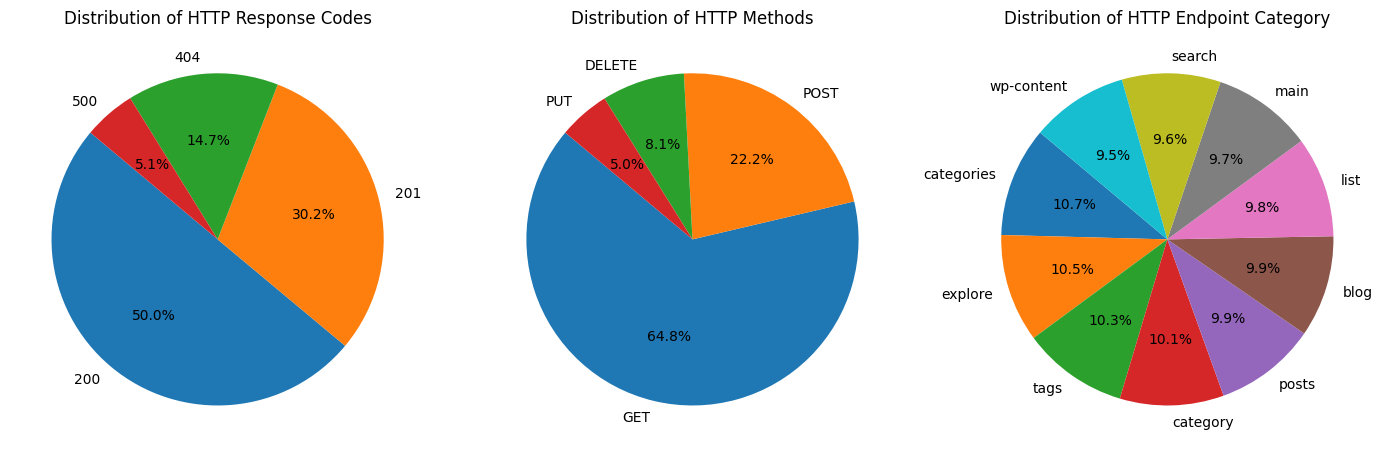

In [4]:
# Function for response code querry
def fetch_response_codes(index, date):
    query = {
        "size": 0,
        "query": {
            "range": {
                "timestamp": {
                    "gte": date,
                    "lte": date,
                    "format": "yyyy-MM-dd"
                }
            }
        },
        "aggs": {
            "response_codes": {
                "terms": {
                    "field": "response_code"
                }
            }
        }
    }
    result = es.search(index=index, body=query)
    buckets = result['aggregations']['response_codes']['buckets']
    return pd.DataFrame([(bkt['key'], bkt['doc_count']) for bkt in buckets], columns=['Response Code', 'Count'])
    
# Function for log method querry
def fetch_methods(index, date):
    query = {
        "size": 0,
        "query": {
            "range": {
                "timestamp": {
                    "gte": date,
                    "lte": date,
                    "format": "yyyy-MM-dd"
                }
            }
        },
        "aggs": {
            "methods": {
                "terms": {
                    "field": "method.keyword"
                }
            }
        }
    }
    result = es.search(index=index, body=query)
    buckets = result['aggregations']['methods']['buckets']
    return pd.DataFrame([(bkt['key'], bkt['doc_count']) for bkt in buckets], columns=['Method', 'Count'])

# Function for log endpoint querry
def fetch_endpoints(index, date):
    query = {
        "size": 0,
        "query": {
            "range": {
                "timestamp": {
                    "gte": date,
                    "lte": date,
                    "format": "yyyy-MM-dd"
                }
            }
        },
        "aggs": {
            "endpoint": {
                "terms": {
                    "field": "endpoint.keyword"
                }
            }
        }
    }
    result = es.search(index=index, body=query)
    buckets = result['aggregations']['endpoint']['buckets']
    return pd.DataFrame([(bkt['key'], bkt['doc_count']) for bkt in buckets], columns=['Endpoint', 'Count'])



# Fetch data
df_codes = fetch_response_codes("web-logs", today)
df_methods = fetch_methods("web-logs", today)
df_endpoint = fetch_endpoints("web-logs", today)

# Set up the matplotlib figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7))

# Pie chart for HTTP response codes
ax1.pie(df_codes['Count'], labels=df_codes['Response Code'], autopct='%1.1f%%', startangle=140)
ax1.set_title('Distribution of HTTP Response Codes')

# Pie chart for HTTP methods
ax2.pie(df_methods['Count'], labels=df_methods['Method'], autopct='%1.1f%%', startangle=140)
ax2.set_title('Distribution of HTTP Methods')

ax3.pie(df_endpoint['Count'], labels=df_endpoint['Endpoint'], autopct='%1.1f%%', startangle=140)
ax3.set_title('Distribution of HTTP Endpoint Category')

# Show the plot
plt.tight_layout()
plt.show()


## RESPONSE TIME ANALYSIS

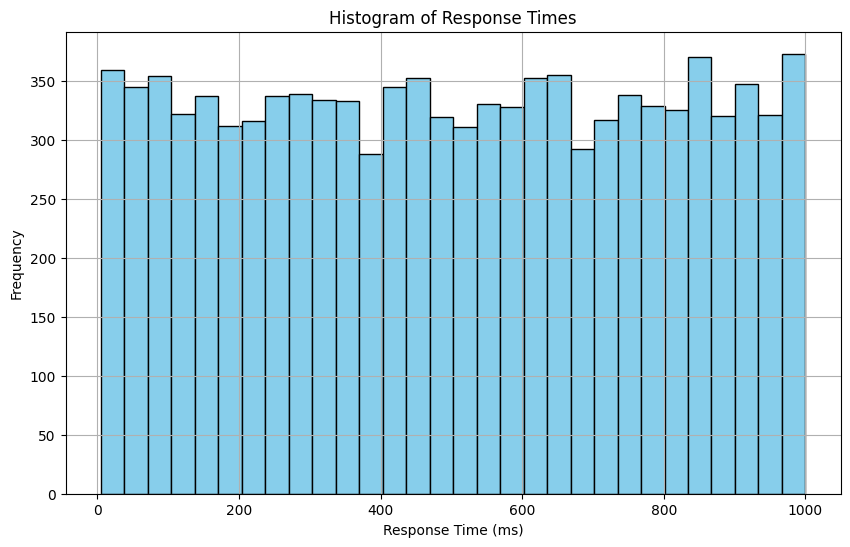

In [5]:
# ES Querry for fetching response times (in seconds)
def fetch_response_times(index, date):
    query = {
        "size": 10000,
        "query": {
            "range": {
                "timestamp": {
                    "gte": date,
                    "lte": date,
                    "format": "yyyy-MM-dd"
                }
            }
        },
        "_source": ["response_time", "timestamp", "endpoint"],
        "sort": [{"timestamp": {"order": "asc"}}]
    }
    result = es.search(index=index, body=query)
    return pd.DataFrame([{
        'timestamp': hit['_source']['timestamp'],
        'response_time': hit['_source']['response_time'],
        'endpoint': hit['_source']['endpoint']
    } for hit in result['hits']['hits']])

df_response = fetch_response_times("web-logs", today)

df_response['timestamp'] = pd.to_datetime(df_response['timestamp'])

# Extract time as hours of the day for better plotting
df_response['time_of_day_hours'] = df_response['timestamp'].dt.hour + df_response['timestamp'].dt.minute / 60 + df_response['timestamp'].dt.second / 3600

# Plot histogram of response times
plt.figure(figsize=(10, 6))
plt.hist(df_response['response_time'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Response Times')
plt.xlabel('Response Time (ms)')
plt.ylabel('Frequency')
plt.grid(True)  
plt.show()
